# NFC extraction testing, part 2

After looking at the generated spectrograms and audio files, I made edits to the duration and frequency for many of the species and stored them in `freqs_and_durations_manual_edits.csv`. I also noticed that the sound files did not seem to be extracted with the call centered. 

This notebook attempts to fix those issues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
import pandas as pd
from pathlib import Path
import random

Load the document which describes the upper and lower frequency limits for bandpassing as well as the approximate duration of the call

In [25]:
freq_limits = pd.read_csv("freqs_and_durations_manual_edits.csv")
freq_limits.head()

,code,low_freq,high_freq,approx_duration,median_duration,approx_minus_median_duration
0,CANG,0.1,10000,0.10,0.093,0.007
1,GWTE,0.1,5000,0.10,0.075,0.025
2,BLSC,1000.0,3000,0.50,0.272,0.228
3,LTDU,0.1,10000,0.10,0.082,0.018
4,BBCU,0.1,5000,0.05,0.042,0.008


Load the table which describes the pairings between annotation files and audio files

In [17]:
tables_to_filenames = pd.read_csv("annotation_audio_pairs.csv", index_col='annotation_file').to_dict()['audio_file']

## Spectrogram creation parameters

In [31]:
# Spectrogram creation parameters
#sample_rate=22050
window_samples = 256
window_type = 'blackman'
decibel_limits = (-80, 0)

# Denoising parameters
#denoise=True
#quantile=0.8
bandpass = True
order = 4

# How many spectrograms to create and where to save them
max_num_examples = 30
create_audio = True
save_audio = True
save_spectrogram = False

## Functions for creating spectrograms

Formatting function to nicely format ticks for frequency (y axis) and time (x axis)

In [19]:
def freq_reformatter(tick_val_hertz, pos):
    """
    Input: float value in Hertz, e.g. 10000.0
    Output: formatted string in kHz, e.g. '10'
    """
    val_khz = tick_val_hertz/1000
    str_format = "%.0f" % val_khz
    if len(str_format) < 2:
        str_format = str_format + '  '
    return str_format

In [20]:
def sec_reformatter(tick_val_sec, pos):
    """
    Input: float value in seconds, e.g. 0.15
    Output: formatted string in milliseconds, e.g. '150'
    """
    val_ms = tick_val_sec*1000
    return "%.0f" % val_ms
    

Function to save nice-looking spectrograms (using the functions above for formatting)

In [41]:
def save_or_plot_spectrogram(s, filename, duration, save=True):
    """Create and save an NFC spectrogram
    
    Inputs:
        s: opensoundscape.spectrogram.Spectrogram object
        filename: where to save the file
        duration: duration of the spectrogram
        save: whether or not to save the file. If not saved, just plots the fig
    """
    plt.subplots(figsize=(duration*30, 5))
    plot = s.plot(inline=False)
    s.plot(inline=False)
    ax = plt.gca()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="y", direction="in", pad=-25, length=5, labelsize=17)
    ax.tick_params(axis="x", direction="in", pad=-20, length=5, labelsize=17)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xticks(np.arange(0, duration, 0.05)[1:])
    ax.set_yticks([2000, 4000, 6000, 8000, 10000])
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(sec_reformatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(freq_reformatter))
    if save:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    plt.close()

## Extraction!

Calls that we've decided should be excluded due to quality, etc.

In [55]:
exclusions = pd.read_csv("exclusions.csv").filename_no_extension.tolist()
exclusions

['SWWB_20151007_190300_PASSERIFORMES_CARDINALIDAE_SPIZA_AMERICANA_DICK_16502.048_16502.08']

CAFO1_20171015_191000_CHARADRIIFORMES_SCOLOPACIDAE_TRINGA_MELANOLEUCA_GRYE_1385.84_1385.882
5000.0 11024.0


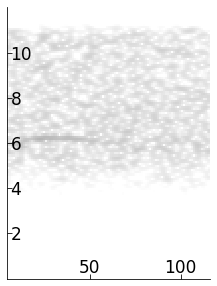

CAFO1_20171015_191000_CHARADRIIFORMES_SCOLOPACIDAE_TRINGA_MELANOLEUCA_GRYE_1385.963_1386.059
0.1 6000.0


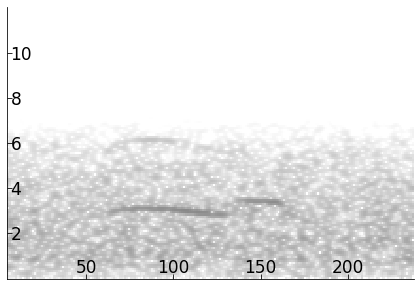

In [54]:
# Keep track of how many examples we have per species
num_examples_per_sp = {}

# Randomly shuffle the files to get a good cross-representation
random.seed(42)
keys = list(tables_to_filenames.keys()) 
random.shuffle(keys) # Randomize which files we view

assets_path = Path("assets")
assets_path.mkdir(exist_ok=True)
metadata = []

# Loop through the files and extract annotations
for txt_file_name in keys[:2]:
    txt_file_path = Path("kearney-nfc_annotations_cleaned").joinpath(txt_file_name)
    audio_file = tables_to_filenames[txt_file_name]
    location_metadata = str(Path(audio_file).parent).strip('/bgfs/jkitzes/ter38/data/kearney-nfc')
    
    # Loop through all annotations in the file
    df = pd.read_csv(txt_file_path, sep='\t')
    for idx, row in list(df.iterrows())[:2]:
        
        # Create the filename containing the info about the call
        bp_low, bp_high, approx_duration = freq_limits.query("code == @alpha")[['low_freq', 'high_freq', 'approx_duration']].values[0]
        file_info = [str(x) for x in row[['Order', 'Family', 'Genus', 'Species', 'Alpha code', 'Begin time (s)', 'End time (s)']].tolist()]
        dirname = assets_path.joinpath(alpha)
        dirname.mkdir(exist_ok=True)
        filename = '_'.join([txt_file_path.stem, *file_info])

        # Decide whether to process this call
        alpha = row['Alpha code']
        if alpha == '?' or filename in exclusions:
            continue
        if alpha not in num_examples_per_sp.keys():
            num_examples_per_sp[alpha] = 1
        elif num_examples_per_sp[alpha] >= max_num_examples:
            continue
        else:
            num_examples_per_sp[alpha] += 1
            
        if alpha in ["BLGR", "BRCR", "COGO", "EVGR", "LALO", "OROR", "RBGU", "SORA", "STSA"]:
            print()
            print(alpha, txt_file_name)
        

        print(filename)

        # Beginning and ending time of the annotation
        begin = row['Begin time (s)']
        end = row['End time (s)']
        
        # Create a longer audio segment to save
        if create_audio:
            audio_dirname = dirname.joinpath('audio')
            audio_dirname.mkdir(exist_ok=True)
            offset = begin - 3
            long_duration = 6
            long_segment = Audio.from_file(audio_file, offset=offset, duration=long_duration)
            if save_audio:
                audio_filename = str(audio_dirname.joinpath(filename)) + '.wav'
                long_segment.save(audio_filename)
                
        
        # Save some info about the file
        metadata.append([location_metadata, txt_file_path.stem, *file_info, offset])

        
        # Create a shorter spectrogram to show on website
        center = (end + begin)/2
        buffer_s = approx_duration/1.4
        offset = center - approx_duration/2 - buffer_s
        duration = approx_duration + buffer_s*2
        overlap_samples = int(window_samples*0.9)
        
        short_segment = Audio.from_file(audio_file, offset=offset, duration=duration)
        print(bp_low, bp_high)
        if bandpass:
            short_segment = short_segment.bandpass(bp_low, bp_high, order=order)
        
        s = Spectrogram.from_audio(
            short_segment, window_samples=window_samples, overlap_samples=overlap_samples, decibel_limits=decibel_limits, window_type=window_type)
        spectrogram_dirname = dirname.joinpath('spectrograms')
        spectrogram_dirname.mkdir(exist_ok=True)
        spectrogram_filename = str(spectrogram_dirname.joinpath(filename)) + '.jpg'
        save_or_plot_spectrogram(s, filename=str(spectrogram_filename), duration=duration, save=save_spectrogram)

## Save record of clips

In [27]:
metadata_df = pd.DataFrame(metadata, columns=[
    'project', 'source_clip', 'order', 'family', 'genus', 'species', 'alpha_code',
    'annotation_start_time', 'annotation_end_time', 'audio_clip_start_time'])
metadata_df.to_csv("clip_metadata.csv")